# Introduction to Adversarial Attacks

# 1. Loading a CNN
To save time, we will use a pretrained CNN (on the CIFAR-10 dataset) in order to test various adversarial methods. It has a straight-forward architecture, which is shown below. To save having to store the model architecture as a file, only the weights can be stored, and the model architecture can be replicated as follows.

In [5]:
import torch
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU, Dropout #All of the necessary layers for this model

loss_fn = torch.nn.CrossEntropyLoss()

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.dropout = Dropout(p=0.3)
        self.conv2 = Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.pooling = MaxPool2d(2,2)
        self.relu = ReLU()
        self.flatten = Flatten()
        self.linear1 = Linear(2048, 128)
        self.linear2 = Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) #Convolution layer
        x = self.pooling(x) #Max Pooling Layer
        x = self.dropout(x) #Dropout Layer
        x = self.conv2(x) #Second Convolution Layer
        x = self.pooling(x) #Second Pooling Layer
        x = self.flatten(x) #Flatten Layer
        x = self.relu(self.linear1(x)) #Regular Layer
        x = self.dropout(x) #Second Dropout Layer
        x = self.linear2(x) #Output Layer
        return x

In [7]:
model = CNN()
model.load_state_dict(torch.load('CNN_weights.pth'))
model.eval() #Puts the model on 'eval mode', stopping Dropout operations

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2048, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

# 2. Loading and Processing Images
Write a function that converts 'truck.jpg' into a transformed pytorch tensor, sizes it to (32,32) , and normalizes it.

Hint: Use transforms from torchvision.transforms
Hint: Use Resize, ToTensor, Normalize

In [228]:
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image

def process_image(path):
    img = Image.open(path)
    transform = Compose([Resize((32,32)), ToTensor(), Normalize(mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5))])
    processedImg = transform(img)
    processedImg = processedImg.unsqueeze(0)
    return processedImg

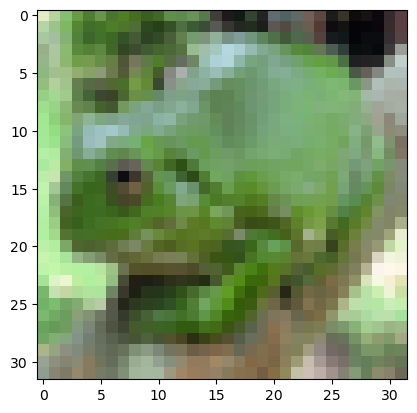

In [234]:
import matplotlib.pyplot as plt

def show_image(img):
    img = img.squeeze(0)
    img = img / 2 + 0.5 #Undo normalization (Normalization = (x - mean) / std)
    plt.imshow(img.permute(1, 2, 0).detach().numpy())

show_image(process_image('frog.jpg'))

## 2a. Making Predictions
Using the function you created above, predict what the model classifies the frog to be.

In [395]:
def prediction(img):
    classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    with torch.no_grad(): #Stops calculating gradients
        prediction = model(img)
        _, pred_class = torch.max(prediction, 1)
    probs = prediction.softmax(dim=-1)
    return pred_class, classes[pred_class], probs[0][pred_class]

print(prediction(process_image('frog.jpg')))

(tensor([6]), 'frog', tensor([0.57]))


# 3. Making an adversarial image using FGSM

In [413]:
import numpy as np

def FGSM_generator(path, y, e = 0.05):
    x = process_image(path)
    x.requires_grad = True
    output = model(x)
    loss = loss_fn(output, y)
    model.zero_grad()
    loss.backward()
    loss_gradient = x.grad.data
    x = x.detach()

    x_dash = x + (e * np.sign(loss_gradient))
    return torch.clamp(x_dash, -1, 1)

path = 'frog.jpg'
x_adv_FGSM = FGSM_generator(path, prediction(process_image(path))[0], e = 0.05)
pred = prediction(x_adv_FGSM)
print(f"Prediction: {pred[1]} with probability {pred[2][0]:.2f}")

Prediction: deer with probability 0.37


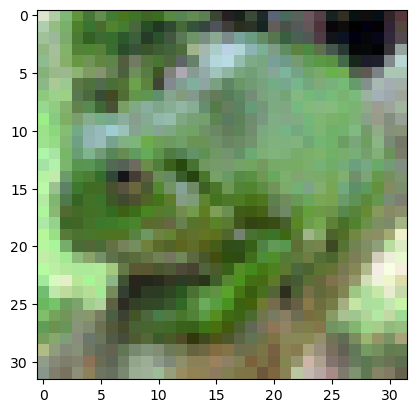

In [379]:
show_image(x_adv_FGSM)

# 4. Making an adversarial image using IGSM 

In [403]:
def IGSM_generator(path, y, e=0.1, alpha=0.01, num_iters=1):

    x = process_image(path)
    x.requires_grad = True
    for i in range(num_iters):
        x.requires_grad = True
        output = model(x)
        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        loss_gradient = x.grad.data
        x = x.detach()
        x = x + alpha * torch.sign(loss_gradient)
        x = torch.clamp(x, x - e, x + e)
        x = torch.clamp(x, -1, 1)
        
    return x

path = 'frog.jpg'
x_adv_IGSM = IGSM_generator(path, prediction(process_image(path))[0], num_iters = 15)
pred = prediction(x_adv_IGSM)
print(f"Prediction: {pred[1]} with probability {pred[2][0]:.2f}")

Prediction: deer with probability 0.44


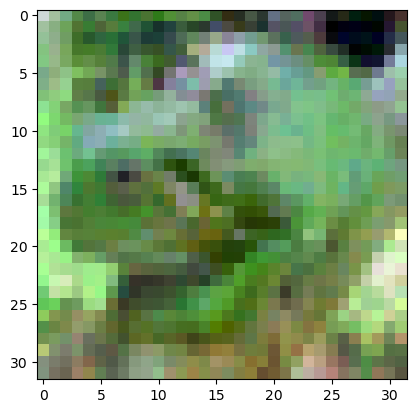

In [405]:
show_image(x_adv_IGSM)

# 5. Making an adversarial image using PGD

In [421]:
def add_noise(img, stdev=0.001, mean=0):
    noise = torch.randn_like(img) * stdev + mean
    return img + noise


def PGD_generator(path, y, e=0.1, alpha=0.01, num_iters=15):
    model.eval()
    x = process_image(path)
    x = add_noise(x)
    x = torch.clamp(x, -1, 1)

    for i in range(num_iters):
        x.requires_grad = True
        output = model(x)
        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        loss_gradient = x.grad.data
        x = x.detach()
        x = x + alpha * torch.sign(loss_gradient)
        x = torch.clamp(x, x - e, x + e)
        x = torch.clamp(x, -1, 1)
        
    return x


path = 'frog.jpg'
x_adv_PGD = PGD_generator(path, prediction(process_image(path))[0], num_iters = 5)
pred = prediction(x_adv_PGD)
print(f"Prediction: {pred[1]} with probability {pred[2][0]:.2f}")

Prediction: deer with probability 0.37


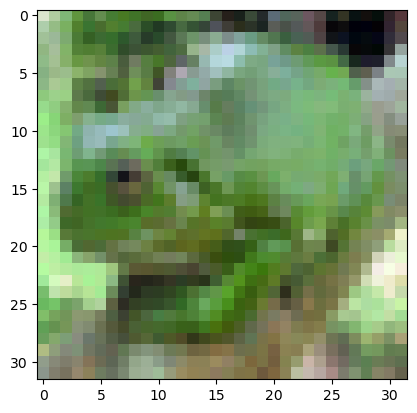

In [389]:
show_image(x_adv_PGD)

# 6. Evaluating Distance


In [419]:
x = process_image('frog.jpg')

def distance(x1, x2, p):
    x = abs(x1 - x2) ** p
    x = x.sum()
    return x ** 1/p

print(f"Distance for FGSM: {distance(x, x_adv_FGSM, 2):.2f}")
print(f"Distance for IGSM: {distance(x, x_adv_IGSM, 2):.2f}")
print(f"Distance for PGD: {distance(x, x_adv_PGD, 2):.2f}")

Distance for FGSM: 3.84
Distance for IGSM: 3.30
Distance for PGD: 3.31
